In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#pip install wandb

Create a siamese network for immage classification

In [3]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tq
import matplotlib.pyplot as plt
from skimage.io import imshow
from pathlib import Path
import numpy as np
import random
import wandb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

load data

In [5]:
#/content/drive/MyDrive/Colab Notebooks/efficent net/
npz = np.load('/content/drive/MyDrive/Colab Notebooks/efficent net/data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


plot some data

In [6]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def plot_image(ix):
    imshow(np.squeeze(X_train[ix,:,:,:]))#Looking at the combined channel
    plt.show()
    labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(Y_train[ix])])

def plot_image_pair(num_img):
    f, axarr = plt.subplots(2)
    axarr[0].imshow(np.squeeze(train_dataset_loader.dataset.right_dat[num_img]))
    axarr[1].imshow(np.squeeze(train_dataset_loader.dataset.left_dat[num_img]))
    plt.show()
    labels = ['equal','not equal']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(train_dataset_loader.dataset.targets[num_img])])


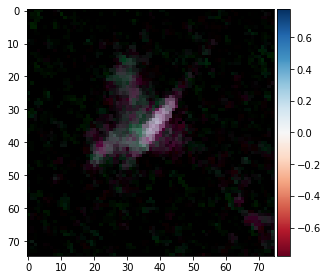

This is: Iceberg


In [7]:
plot_image(101)

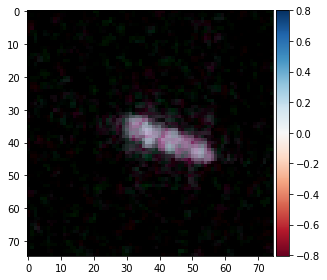

This is: Ship


In [8]:
plot_image(100)

create a base network

In [9]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.apply(self._init_weights)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5,7,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
        )


        self.fc1=nn.Sequential(
            nn.Linear(2268,18),
            nn.Sigmoid())

        self.out = nn.Sequential(
            nn.Linear(18,1)) 
        

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=torch.sqrt(2/module.in_channels))
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=torch.sqrt(2/module.in_channels))
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=torch.sqrt(2/module.in_channels))
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=torch.sqrt(2/module.in_channels))
        
    def forward_once(self,inp):
        inp=self.conv(inp)
        inp=self.fc1(inp)
        return inp

    def forward(self, inp1, inp2):
        out1=self.forward_once(inp1)
        out2=self.forward_once(inp2)
        dis=torch.abs(out2-out1)
        out=self.out(dis)
        return out

Create the pair of images to train on

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, left_list, right_list,targets, transform):
        self.left_dat = left_list
        self.right_dat = right_list
        self.targets = targets
        self.transform = transform
        self.imag_nomr = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        left_img = self.left_dat[idx]
        right_img = self.right_dat[idx]
        targets = self.targets[idx]
        
        left_img = np.transpose(left_img,(2,0,1))
        left_img = torch.Tensor(left_img)

        right_img = np.transpose(right_img,(2,0,1))
        right_img = torch.Tensor(right_img)

        # nomalization of immages
        left_img = self.imag_nomr(left_img)
        right_img = self.imag_nomr(right_img)
                        
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
    
        return left_img, right_img, targets




In [11]:
def crate_Pairs_data(image_list,label_list, pairs = 5):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(0.)
            else:# Not the same
                targets.append(1.)
    
    return left_input,right_input,targets

In [12]:
X_index, y_index = range(X_train.shape[0]), range(Y_train.shape[0])
# test 20% 
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X_index, y_index,
    test_size=0.2, shuffle = True, random_state = 42)

# validation 20% training 60%
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_index, y_train_index, 
    test_size=0.20, random_state= 42) 

In [13]:
len(X_train_index),len(X_val_index),len(X_test_index)


(2632, 658, 823)

Data augemtation

In [14]:
transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.70),
    transforms.RandomVerticalFlip(0.70),
    transforms.RandomGrayscale(0.70),
    )

Train data

In [15]:
num_workers = 2
bs = 64

In [16]:
image_list_train = np.split(X_train[X_train_index],len(X_train_index))
label_list_train = np.split(Y_train[y_train_index],len(y_train_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_train,label_list=label_list_train,pairs=5)
train_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=transform)


train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs,shuffle=False, num_workers=num_workers)

del image_list_train,label_list_train,train_dataset

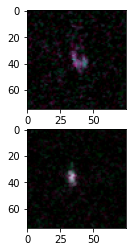

This is: not equal


In [17]:
plot_image_pair(1)

Validation data

In [18]:
image_list_val = np.split(X_train[X_val_index],len(X_val_index))
label_list_val = np.split(Y_train[y_val_index],len(y_val_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_val,label_list=label_list_val,pairs=5)
validation_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

validation_dataset_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

del image_list_val,label_list_val,validation_dataset

Test data

In [19]:
image_list_test = np.split(X_train[X_test_index],len(X_test_index))
label_list_test = np.split(Y_train[y_test_index],len(y_test_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_test,label_list=label_list_test,pairs=5)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1,shuffle=False, num_workers=2)

del image_list_test,label_list_test,test_dataset

In [20]:
del X_train,Y_train

train model

In [21]:
net = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 2.5e-4 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


train_on_gpu = torch.cuda.is_available()
train_on_gpu

if train_on_gpu:
    net.cuda()

In [26]:
def correct_out(output,label,TrueNegative,FalseNegative,TruePositive,FalsePositive,thresholds):
    for j in range(output.size(0)):
        cos = F.cosine_similarity(output[j],label[j],dim=0)
        if (cos>thresholds) and (label[j]==1):
            TrueNegative+=1
        elif (cos>thresholds) and (label[j]==0):
            FalseNegative+=1
        elif (cos<thresholds) and (label[j]==0):
            TruePositive+=1
        elif (cos<thresholds) and (label[j]==1):
            FalsePositive+=1


    return TrueNegative,FalseNegative,TruePositive,FalsePositive

In [23]:
wandb.init(settings=wandb.Settings(start_method="thread"),
           project="siamese_net",
           config={"learning_rate": 0.01,
                   "architecture": "Siamese Network",
                   "dataset": "Iceberg",
                   "epochs": 20,})

wandb: Currently logged in as: thomas-borsani1. Use `wandb login --relogin` to force relogin


In [27]:
n_epochs = 30

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    TN=0
    FN=0
    TP=0
    FP=0

    ###################
    #   MODEL TRAIN   #
    ###################
    net.train()
    bar = tq(train_dataset_loader, postfix={"train_loss":0.0})
    config = wandb.config

    for img0, img1, label in bar:
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()
        output = net(img0, img1)

        loss = criterion(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # stats
        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP,thresholds=0.5)
       
        bar.set_postfix({"Train loss":loss.item(),
        #"Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
        "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
        "correct_out":(TN+TP)/total})

    # scheduler
    scheduler.step()
    
    # report stat
    if TP > 0:    
        Pr = TP / (TP + FP)
        Rec = TP /(TP + FN)
        Acc = (TP+TN)/(TP + TN + FN + FP)
        Jaccard = TP/(TP + FN + FP) 
    else :
        Pr = 0
        Rec = 0
        Acc = 0
        Jaccard = 0 
    lr_rate = [param_group['lr'] for param_group in optimizer.param_groups][0]
    train_metrics = {"train/loss": loss.item(),"train/Precision":Pr,"train/Recall":Rec,"train/Jaccard" :Jaccard, 
                       "train/accuracy": Acc,"lr_rate": lr_rate}
    wandb.log({**train_metrics})

    print("Accuracy training loss after {} epochs : {}".format(epoch, Acc))
    ######################   
    #  MODEL VALIDATION  #
    ######################
    net.eval()
    del img0, img1, label, bar
    TN=0
    FN=0
    TP=0
    FP=0

    with torch.no_grad():
        bar = tq(validation_dataset_loader, postfix={"valid_loss":0.0})
        for img0, img1, label in bar:
            
            if train_on_gpu:
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            output = net(img0, img1)
            loss = criterion(output, label.unsqueeze(1))
            
            total = label.size(0)
            TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP,thresholds=0.5)

            bar.set_postfix({"Validation loss":loss.item(),
            #"Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
            "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
            "correct_out":(TP+TN)/total})

    if TP > 0:    
        Pr = TP / (TP + FP)
        Rec = TP /(TP + FN)
        Acc = (TP+TN)/(TP + TN + FN + FP)
        Jaccard = TP/(TP + FN + FP) 
    else :
        Pr = 0
        Rec = 0
        Acc = 0
        Jaccard = 0 

    
    val_metrics = {"val/loss": loss.item(),"val/Precision":Pr,"val/Recall":Rec,"val/Jaccard" :Jaccard, 
                       "val/accuracy": Acc}
    wandb.log({**val_metrics})
    
    print("Average validation loss after {} epochs : {}".format(epoch, Acc))


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 1 epochs : 0.7614741641337386


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 1 epochs : 0.8455927051671732


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 2 epochs : 0.8196808510638298


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 2 epochs : 0.8504559270516717


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 3 epochs : 0.8445288753799393


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 3 epochs : 0.9024316109422492


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>    
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    
self._shutdown_workers()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/lib/python3.8/multiprocessing/process.py"

Accuracy training loss after 4 epochs : 0.8601823708206687


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 4 epochs : 0.8987841945288754


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 5 epochs : 0.8687689969604864


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 5 epochs : 0.9091185410334347


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 6 epochs : 0.8797872340425532


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 6 epochs : 0.9227963525835866


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 7 epochs : 0.8904255319148936


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 7 epochs : 0.9297872340425531


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 8 epochs : 0.8971124620060791


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 8 epochs : 0.9258358662613981


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 9 epochs : 0.90919452887538


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 9 epochs : 0.9209726443768997


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>Traceback (most recent call last):


  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()        
self._shutdown_workers()self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers


      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  Fi

Accuracy training loss after 10 epochs : 0.9101823708206687


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 10 epochs : 0.9376899696048632


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 11 epochs : 0.9177051671732522


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 11 epochs : 0.9367781155015198


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 12 epochs : 0.9227203647416413


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 12 epochs : 0.9325227963525836


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 13 epochs : 0.9287234042553192


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 13 epochs : 0.9373860182370821


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 14 epochs : 0.9347264437689969


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 14 epochs : 0.9319148936170213


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 15 epochs : 0.9325987841945289


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 15 epochs : 0.9340425531914893


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 16 epochs : 0.941033434650456


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    self._shutdown_workers()    
Exception ignored in: if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>
    
if w.is_alive():  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/usr/local/l

Average validation loss after 16 epochs : 0.943161094224924


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/ut

Accuracy training loss after 17 epochs : 0.9439969604863222


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 17 epochs : 0.941033434650456


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 18 epochs : 0.9501519756838905


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 18 epochs : 0.937082066869301


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 19 epochs : 0.9497720364741641


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 19 epochs : 0.941033434650456


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 20 epochs : 0.9547112462006079


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 20 epochs : 0.9422492401215805


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 21 epochs : 0.9544072948328267


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 21 epochs : 0.9480243161094225


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 22 epochs : 0.9570668693009119


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 22 epochs : 0.943161094224924


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>

AssertionErrorTraceback (most recent call last):
Exception ignored in: :   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>    

self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3

Accuracy training loss after 23 epochs : 0.959726443768997


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 23 epochs : 0.9452887537993921


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 24 epochs : 0.9585866261398176


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 24 epochs : 0.9498480243161094


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 25 epochs : 0.9636018237082067


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 25 epochs : 0.9455927051671732


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 26 epochs : 0.9629939209726444


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 26 epochs : 0.947112462006079


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 27 epochs : 0.9625379939209726


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 27 epochs : 0.947112462006079


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 28 epochs : 0.9664133738601823


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 28 epochs : 0.9468085106382979


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'    Exception ignored in: 
AssertionErrorself._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff53186a4c0>: 
can only test a child process  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dat

Accuracy training loss after 29 epochs : 0.9677811550151976


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 29 epochs : 0.9492401215805472


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 30 epochs : 0.9668693009118541


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 30 epochs : 0.947112462006079


In [ ]:
#torch.save(net,'/content/drive/MyDrive/Colab Notebooks/efficent net/net_89')

Evaluate on test set

In [28]:
with torch.no_grad():
  TN=0
  FN=0
  TP=0
  FP=0
  net.eval()
  print("Testing...")
  bar = tq(test_dataset_loader, postfix={"Accuracy":0.0})

  for img0, img1, label in bar:
      
      if train_on_gpu:
          img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
      
      output = net(img0, img1)
      
      total = label.size(0)
      TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP,thresholds=0.5)

      if TP > 0:    
        Pr = TP / (TP + FP)
        Rec = TP /(TP + FN)
        Acc = (TP+TN)/(TP + TN + FN + FP)
        Jaccard = TP/(TP + FN + FP) 
      else :
        Pr = 0
        Rec = 0
        Acc = 0
        Jaccard = 0 
      bar.set_postfix(ordered_dict={"Accuracy":(Acc)*100})  

  print('{} correct predictions out of {}\nAccuracy : {:.2f}\nJaccard : {:.2f}'.format((TP+TN),(TP+TN+FN+FP), (Acc)*100,Jaccard*100))


Testing...


  0%|          | 0/4115 [00:00<?, ?it/s, Accuracy=0]

3843 correct predictions out of 4115
Accuracy : 93.39
Jaccard : 88.38


In [29]:
def extract_patch_cam(net, img_l,img_r, patch_width, patch_height):
    assert not img_l.shape[-2] % patch_height and not img_l.shape[-1] % patch_width
    with torch.no_grad():
        pred = net(img_l,img_r).max(1)[1].item()  
        num_patches_x = img_l.shape[-2] // patch_height
        num_patches_y = img_l.shape[-1] // patch_width
        ret = torch.zeros(1, num_patches_y, num_patches_x)
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                tmp_imgL = img_l.clone()
                tmp_imgR = img_r.clone()
                tmp_imgL[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                tmp_imgR[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                ret[:, i, j] = torch.softmax(net(tmp_imgL,tmp_imgR), dim=1)[0, pred].item()
    ret = 1 - ret
    return ret, pred

Pred: [0]
Ground truth: [0.0]


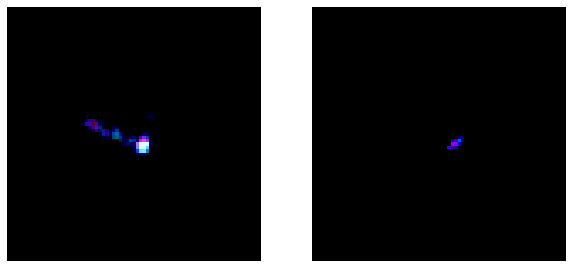

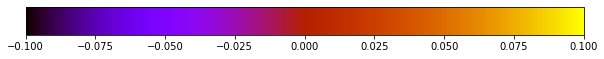

In [30]:
classes = ('iceberg','ship')

idx = 0
patch_width = 5
patch_height = 5

upsample_layer_cpu = torch.nn.Upsample(size=(75, 75), mode='bilinear', align_corners=True).cuda()
data = next(iter(test_dataset_loader))
example_l = upsample_layer_cpu(data[0][idx:idx+1]).cuda()
example_r = upsample_layer_cpu(data[1][idx:idx+1]).cuda()
label = data[2][idx:idx+1].item()
heatmap, pred = extract_patch_cam(net, img_l=example_l,img_r=example_r, patch_width=patch_width, patch_height=patch_height)
print(f"Pred: {[pred]}")
print(f"Ground truth: {[label]}")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2): axes[i].axis("off")
axes[0].imshow(example_l.cpu()[0].permute(1, 2, 0))
axes[1].imshow(example_r.cpu()[0].permute(1, 2, 0))
#axes[2].imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")